# Explorations into PSF generation and timing

The current PSF generation is the dominant time step in our grism simulations. This notebook aims to explore whether there is a way to
speed up this process.

In [1]:
import numpy as np
import psf_grid_utils as pgu
import image_utils as iu
import time

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

psf_grid_data_read environment variable has not been set


## Explore gridded PSF

In [2]:
# Make a temporary version of the PSF grid evaluation function to fix a bug with a too-large box
from image_utils import mag2flux

def star_postage_grid_bugfix(psf_grid, mag, detx=2044, dety=2044, fov_pixels=364):
    flux = mag2flux(mag)

    fov_pixels_half = fov_pixels // 2

    x_0 = int(detx)
    y_0 = int(dety)
    y, x = np.mgrid[y_0-fov_pixels_half:y_0+fov_pixels_half, x_0-fov_pixels_half:x_0+fov_pixels_half]

    psf = psf_grid.evaluate(x=x, y=y, x_0=detx, y_0=dety, flux=flux).astype(np.float32)
    return psf

In [3]:
lam = 15000.0 # Angstroms
det_num = 1 # SCA number -- just pick one

psf_grid = pgu.create_grid_one_detector(det_num, lam, save=False, fov_pixels=364) 

Attempted to get aberrations at field point (0, 0) which is outside the range of the reference data; approximating to nearest interpolated point (37.65020753047329, 0.00929405271062933)



Running instrument: WFI, filter: GRISM0
  Running detector: WFI01
    Position 1/16: (0, 0) pixels


Attempted to get aberrations at field point (0, 1365) which is outside the range of the reference data; approximating to nearest interpolated point (37.3132537124476, 1365.0092108747747)


    Position 1/16 centroid: (181.3644597225352, 181.4879183178808)
    Position 2/16: (0, 1365) pixels


Attempted to get aberrations at field point (0, 2730) which is outside the range of the reference data; approximating to nearest input grid point


    Position 2/16 centroid: (181.35821217333492, 181.48782492266372)
    Position 3/16: (0, 2730) pixels


Attempted to get aberrations at field point (0, 4095) which is outside the range of the reference data; approximating to nearest input grid point


    Position 3/16 centroid: (181.35233169695684, 181.48773733037328)
    Position 4/16: (0, 4095) pixels
    Position 4/16 centroid: (181.35233169695684, 181.48773733037328)
    Position 5/16: (1365, 0) pixels
    Position 5/16 centroid: (181.36514509643396, 181.51944350865045)
    Position 6/16: (1365, 1365) pixels


Attempted to get aberrations at field point (1365, 2730) which is outside the range of the reference data; approximating to nearest interpolated point (1364.927908526484, 2633.0129376299355)


    Position 6/16 centroid: (181.35909382889471, 181.51964894669212)
    Position 7/16: (1365, 2730) pixels


Attempted to get aberrations at field point (1365, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (1363.9132906529774, 2633.0136918057583)


    Position 7/16 centroid: (181.3570686246541, 181.52552201858524)
    Position 8/16: (1365, 4095) pixels
    Position 8/16 centroid: (181.35706501190649, 181.52549315699508)
    Position 9/16: (2730, 0) pixels
    Position 9/16 centroid: (181.36514578317306, 181.54946605549935)
    Position 10/16: (2730, 1365) pixels


Attempted to get aberrations at field point (2730, 2730) which is outside the range of the reference data; approximating to nearest interpolated point (2729.927154350661, 2631.9983197564293)


    Position 10/16 centroid: (181.36394565029178, 181.5584728374721)
    Position 11/16: (2730, 2730) pixels


Attempted to get aberrations at field point (2730, 4095) which is outside the range of the reference data; approximating to nearest interpolated point (2728.912536477155, 2631.999073932252)


    Position 11/16 centroid: (181.36192228291637, 181.56433865187205)
    Position 12/16: (2730, 4095) pixels


Attempted to get aberrations at field point (4095, 0) which is outside the range of the reference data; approximating to nearest interpolated point (4076.2481767288878, -0.023150399100131835)


    Position 12/16 centroid: (181.36191867918694, 181.56430980775676)
    Position 13/16: (4095, 0) pixels


Attempted to get aberrations at field point (4095, 1365) which is outside the range of the reference data; approximating to nearest interpolated point (4074.562994112187, 1364.9747691285336)


    Position 13/16 centroid: (181.36897592000656, 181.58491470897715)
    Position 14/16: (4095, 1365) pixels


Attempted to get aberrations at field point (4095, 2730) which is outside the range of the reference data; approximating to nearest input grid point


    Position 14/16 centroid: (181.36782863442895, 181.59404326585917)
    Position 15/16: (4095, 2730) pixels


Attempted to get aberrations at field point (4095, 4095) which is outside the range of the reference data; approximating to nearest input grid point


    Position 15/16 centroid: (181.36668958165868, 181.60251011488646)
    Position 16/16: (4095, 4095) pixels
    Position 16/16 centroid: (181.36668958165868, 181.60251011488646)


In [4]:
# This contains lots of meta information
psf_grid.meta

{'instrume': ('WFI', 'Instrument name'),
 'detector': ('WFI01', 'Detector name'),
 'filter': ('GRISM0', 'Filter name'),
 'pupilopd': ('upscaled_HST_OPD.fits', 'Pupil OPD source name'),
 'opd_file': ('upscaled_HST_OPD.fits', 'Pupil OPD file name'),
 'opdslice': (0, 'Pupil OPD slice number'),
 'fovpixel': (364, 'Field of view in pixels (full array)'),
 'fov': (39.260217542, 'Field of view in arcsec (full array)'),
 'oversamp': (1, 'Oversampling factor for FFTs in computation'),
 'det_samp': (4, 'Oversampling factor for MFT to detector plane'),
 'nwaves': (1, 'Number of wavelengths used in calculation'),
 'pupil': ('GRISM', 'Pupil plane mask'),
 'det_yx0': ('(0.5, 0.5)', "The #0 PSF's (y,x) detector pixel position"),
 'det_yx1': ('(1365.5, 0.5)', "The #1 PSF's (y,x) detector pixel position"),
 'det_yx2': ('(2730.5, 0.5)', "The #2 PSF's (y,x) detector pixel position"),
 'det_yx3': ('(4095.5, 0.5)', "The #3 PSF's (y,x) detector pixel position"),
 'det_yx4': ('(0.5, 1365.5)', "The #4 PSF's (

In [4]:
psf_grid.data.shape

(16, 364, 364)

In [5]:
# Note that our default pixels are not oversampled
print(f"Oversampling factor : {psf_grid.meta['oversampling']}")

# Print out the PSF positions
print(f"PSF positions (xypos) :")
for i in range(len(psf_grid.meta['grid_xypos'])):
    print(f"  {i:2d} : {psf_grid.meta['grid_xypos'][i]}")

Oversampling factor : 1
PSF positions (xypos) :
   0 : (0.5, 0.5)
   1 : (0.5, 1365.5)
   2 : (0.5, 2730.5)
   3 : (0.5, 4095.5)
   4 : (1365.5, 0.5)
   5 : (1365.5, 1365.5)
   6 : (1365.5, 2730.5)
   7 : (1365.5, 4095.5)
   8 : (2730.5, 0.5)
   9 : (2730.5, 1365.5)
  10 : (2730.5, 2730.5)
  11 : (2730.5, 4095.5)
  12 : (4095.5, 0.5)
  13 : (4095.5, 1365.5)
  14 : (4095.5, 2730.5)
  15 : (4095.5, 4095.5)


In [6]:
# Generate a set of random positions
nstars = 100
rng = np.random.default_rng(42)

# Positions
min_pos = 0.0
max_pos = 4088.0
xpos = rng.uniform(min_pos, max_pos, nstars)
ypos = rng.uniform(min_pos, max_pos, nstars)
mag = 17.0

print(f"Minmax of x positions : {xpos.min():.1f} {xpos.max():.1f}")
print(f"Minmax of y positions : {ypos.min():.1f} {ypos.max():.1f}")

t1 = time.time()
for istar in range(nstars):
    x = xpos[istar]
    y = ypos[istar]
    psf = star_postage_grid_bugfix(psf_grid, mag, detx=x, dety=y)
t2 = time.time()
print(f"Time to generate {nstars} stars : {t2 - t1:.3f} seconds")

Minmax of x positions : 30.1 3988.3
Minmax of y positions : 88.4 4056.8
Time to generate 100 stars : 3.498 seconds


In [7]:
psf.shape

(364, 364)

## A Simpler Gridding Class

Our next step is to build a simplified version of the grid class. This will just do a bilinear interpolation of the PSF grid, but nothing more than that.

In [8]:
# We are currently using an older version of photutils where a few of the PSF grid functions 
# are not available.
# We therefore duplicate these here. At some point we should see if we can update photutils
# and deprecate these.
def _v2_find_bounding_points(psf_grid, x, y):
    """Find the grid points surrounding the point (x0, y0)."""
    xgrid = psf_grid._xgrid
    ygrid = psf_grid._ygrid

    # Find the indices of the grid points that bound (x, y)
    x_idx = np.searchsorted(xgrid, x) - 1
    y_idx = np.searchsorted(ygrid, y) - 1

    # Ensure indices are within bounds
    x_idx = np.clip(x_idx, 0, len(xgrid) - 2)
    y_idx = np.clip(y_idx, 0, len(ygrid) - 2)

    # Find the four bounding points in the sorted grid
    # (x0, y0) is the lower-left corner of the grid
    # (x1, y1) is the upper-right corner of the grid
    x0, x1 = xgrid[x_idx], xgrid[x_idx + 1]
    y0, y1 = ygrid[y_idx], ygrid[y_idx + 1]

    # Find the indices of these points in grid_xypos
    xcoords, ycoords = psf_grid.grid_xypos.T
    lower_left = np.where((xcoords == x0) & (ycoords == y0))[0][0]
    lower_right = np.where((xcoords == x1) & (ycoords == y0))[0][0]
    upper_left = np.where((xcoords == x0) & (ycoords == y1))[0][0]
    upper_right = np.where((xcoords == x1) & (ycoords == y1))[0][0]

    grid_idx = np.array((lower_left, lower_right, upper_left, upper_right))
    grid_xy = np.array((x0, x1, y0, y1))

    return grid_idx, grid_xy

def _v2_calc_bilinear_weights(x, y, grid_xy):
    """Calculate the bilinear interpolation weights for the point (x, y) based on the bounding grid points."""
    x0, x1, y0, y1 = grid_xy

    # Calculate the weights
    w_x0 = (x1 - x) / (x1 - x0)
    w_x1 = (x - x0) / (x1 - x0)
    w_y0 = (y1 - y) / (y1 - y0)
    w_y1 = (y - y0) / (y1 - y0)

    # Combine the weights
    weights = np.array([w_x0 * w_y0, w_x1 * w_y0, w_x0 * w_y1, w_x1 * w_y1])

    return weights


# My original plan was to rewrite the gridded PSF class, but instead I think I can just hack 
# this on, using the built in terms. If that is too slow, we can always try other approaches.
def psf_grid_evaluate_fast(psf_grid, x0, y0, mag):
    flux = iu.mag2flux(mag)
    grid_idx, grid_xy = _v2_find_bounding_points(psf_grid, x0, y0)
    weights = _v2_calc_bilinear_weights(x0, y0, grid_xy)

    result = 0
    for idx, weight in zip(grid_idx, weights, strict=True):
        result += weight * psf_grid.data[idx]

    return result * flux

In [9]:
# Repeat the timing with the new function
mag = 17.0
t1 = time.time()
for istar in range(nstars):
    x = xpos[istar]
    y = ypos[istar]
    psf = psf_grid_evaluate_fast(psf_grid, x, y, mag)
t2 = time.time()
print(f"Time to generate {nstars} stars : {t2 - t1:.3f} seconds")

Time to generate 100 stars : 0.039 seconds


Shapes : PSF1 (364, 364) PSF2 (364, 364)
Sum flux PSF1 : 6291.824 PSF2 : 6291.870
min PSF1 : -24.363 PSF2 : 0.000
max PSF1 : 1115.220 PSF2 : 851.292


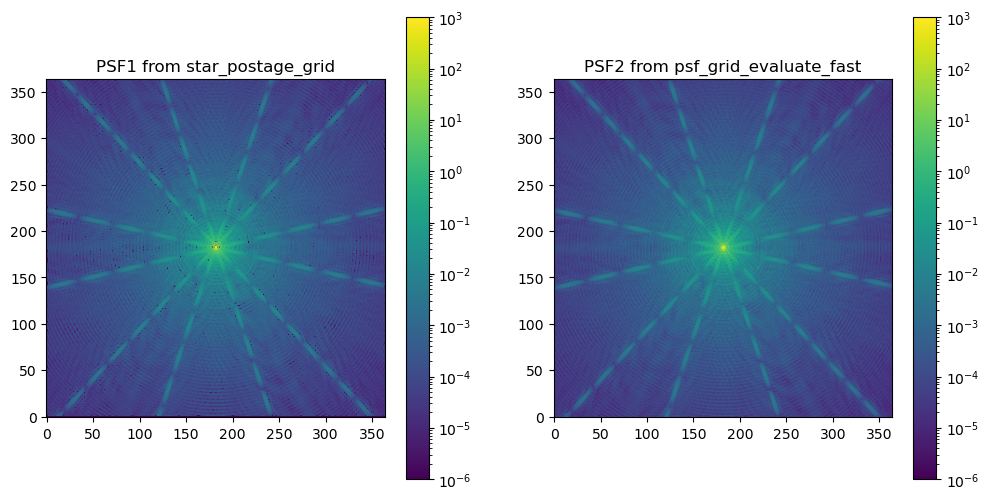

In [10]:
# Explore a little more carefully 
mag = 17.0
psf1 = star_postage_grid_bugfix(psf_grid, mag, detx=2044.0, dety=2044.0)
psf2 = psf_grid_evaluate_fast(psf_grid, 2044.0, 2044.0, mag)

print(f"Shapes : PSF1 {psf1.shape} PSF2 {psf2.shape}")
print(f"Sum flux PSF1 : {np.sum(psf1):.3f} PSF2 : {np.sum(psf2):.3f}")
print(f"min PSF1 : {np.min(psf1):.3f} PSF2 : {np.min(psf2):.3f}")
print(f"max PSF1 : {np.max(psf1):.3f} PSF2 : {np.max(psf2):.3f}")

# Clip the PSFs for better visibility, use 1.e-10 as minimum, but no maximum
psf1 = np.clip(psf1, 1e-10, None)
psf2 = np.clip(psf2, 1e-10, None)

# Display the PSFs using a logarithmic scale for better visibilit
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(psf1, origin='lower', cmap='viridis', norm=LogNorm(vmin=1e-6, vmax=1e3))
plt.title("PSF1 from star_postage_grid")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf2, origin='lower', cmap='viridis', norm=LogNorm(vmin=1e-6, vmax=1e3))
plt.title("PSF2 from psf_grid_evaluate_fast")
plt.colorbar()
plt.show()

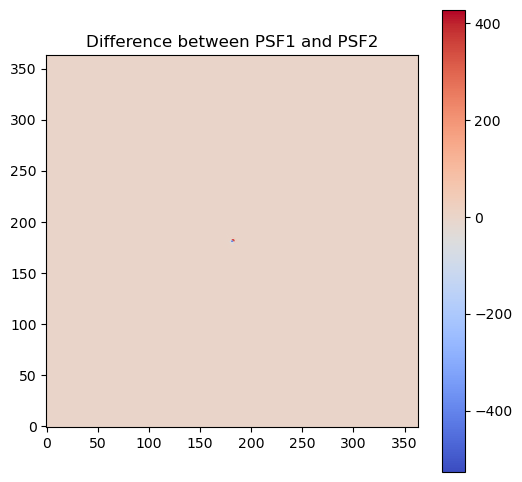

In [11]:
# Also plot the difference
psf_diff = psf1 - psf2
plt.figure(figsize=(6, 6))
plt.imshow(psf_diff, origin='lower', cmap='coolwarm')
plt.title("Difference between PSF1 and PSF2")
plt.colorbar()
plt.show()

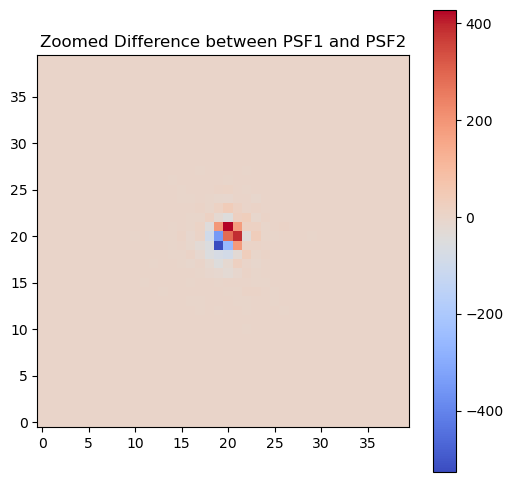

In [12]:
# Zoom into the central region 40x40 pixels of the difference 
zoom_size = 40
pixelcen = psf_diff.shape[0] // 2
psf_diff_zoom = psf_diff[pixelcen-zoom_size//2:pixelcen+zoom_size//2, pixelcen-zoom_size//2:pixelcen+zoom_size//2]
plt.figure(figsize=(6, 6))
plt.imshow(psf_diff_zoom, origin='lower', cmap='coolwarm')
plt.title("Zoomed Difference between PSF1 and PSF2")
plt.colorbar()
plt.show()

### Grid position check

Loop over the grid positions and make sure that the code returns the same grids.

In [13]:
mag = 26.5 # Zero point magnitude for Roman
print(f"Using magnitude {mag} for PSF evaluation")
print(f"Flux for magnitude {mag} : {iu.mag2flux(mag):.3f}")

for ii, (xi, yi) in enumerate(psf_grid.grid_xypos):
    psf1 = psf_grid.data[ii]
    psf2 = psf_grid_evaluate_fast(psf_grid, xi, yi, mag)
    maxdiff = np.max(np.abs(psf1 - psf2))
    print(f"Max difference for PSF at ({xi}, {yi}) : {maxdiff:.3f}")
    if maxdiff > 1e-5:
        print(f"WARNING!!! Significant difference detected for PSF at ({xi}, {yi})")

Using magnitude 26.5 for PSF evaluation
Flux for magnitude 26.5 : 1.000
Max difference for PSF at (0.5, 0.5) : 0.000
Max difference for PSF at (1365.5, 0.5) : 0.000
Max difference for PSF at (2730.5, 0.5) : 0.000
Max difference for PSF at (4095.5, 0.5) : 0.000
Max difference for PSF at (0.5, 1365.5) : 0.000
Max difference for PSF at (1365.5, 1365.5) : 0.000
Max difference for PSF at (2730.5, 1365.5) : 0.000
Max difference for PSF at (4095.5, 1365.5) : 0.000
Max difference for PSF at (0.5, 2730.5) : 0.000
Max difference for PSF at (1365.5, 2730.5) : 0.000
Max difference for PSF at (2730.5, 2730.5) : 0.000
Max difference for PSF at (4095.5, 2730.5) : 0.000
Max difference for PSF at (0.5, 4095.5) : 0.000
Max difference for PSF at (1365.5, 4095.5) : 0.000
Max difference for PSF at (2730.5, 4095.5) : 0.000
Max difference for PSF at (4095.5, 4095.5) : 0.000


### Compare against a direct get_psf run

This is a simple test to compare results. 

In [24]:
psf1 = iu.get_psf(wavelength=lam*1e-10, det="SCA01", detx=2044.0, dety=2044.0)
psf1.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU      53   (728, 728)   float64   
  1  DET_SAMP      1 ImageHDU        55   (364, 364)   float64   
  2  OVERDIST      1 ImageHDU        54   (728, 728)   float64   
  3  DET_DIST      1 ImageHDU        55   (364, 364)   float64   


Size of PSF1 HDU1 data: (364, 364)


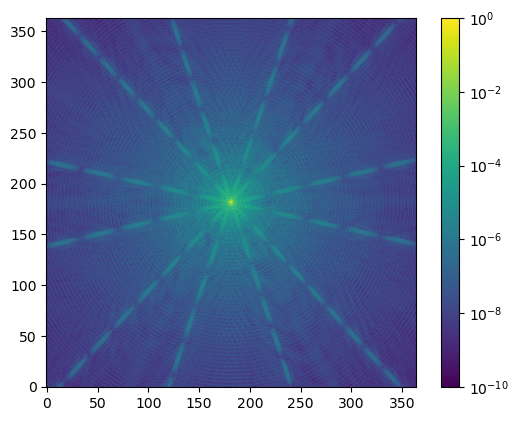

In [27]:
# Use HDU1 to get the detector sampled PSF here, instead of the full PSF
print("Size of PSF1 HDU1 data:", psf1[1].data.shape)

plt.imshow(psf1[1].data, origin='lower', cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e0))
plt.colorbar()
plt.show()

Using magnitude 26.5 for PSF evaluation


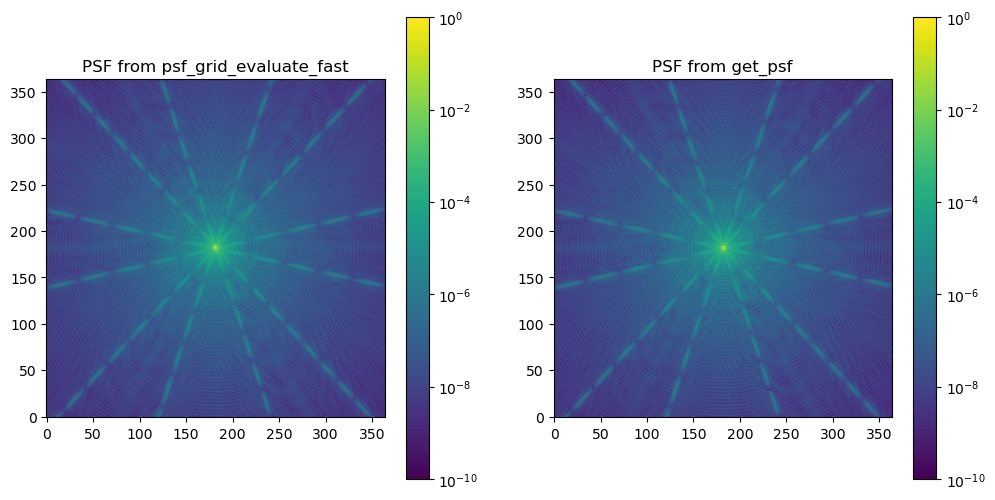

In [29]:
# Do a comparison with the interpolation problem
x0 = 2044.0
y0 = 2044.0
mag_zero = 26.5 # Zero point magnitude for Roman
print(f"Using magnitude {mag_zero} for PSF evaluation")

# Compare the PSF from the grid with the one from get_psf
psf_grid_eval = psf_grid_evaluate_fast(psf_grid, x0, y0, mag_zero)
psf_get_psf_hdu = iu.get_psf(wavelength=lam*1e-10, det="SCA01", detx=x0, dety=y0)
psf_get_psf = psf_get_psf_hdu[1].data

# Plot these two PSFs side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(psf_grid_eval, origin='lower', cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e0))
plt.title("PSF from psf_grid_evaluate_fast")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(psf_get_psf, origin='lower', cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e0))
plt.title("PSF from get_psf")
plt.colorbar()
plt.show()

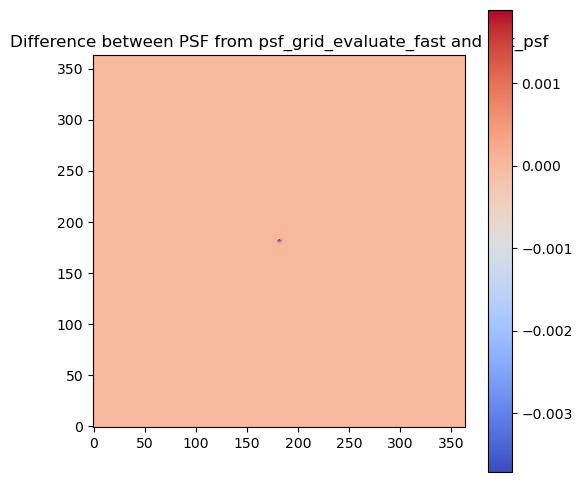

In [30]:
# Difference plot
psf_diff = psf_grid_eval - psf_get_psf
plt.figure(figsize=(6, 6))
plt.imshow(psf_diff, origin='lower', cmap='coolwarm')
plt.title("Difference between PSF from psf_grid_evaluate_fast and get_psf")
plt.colorbar()
plt.show()

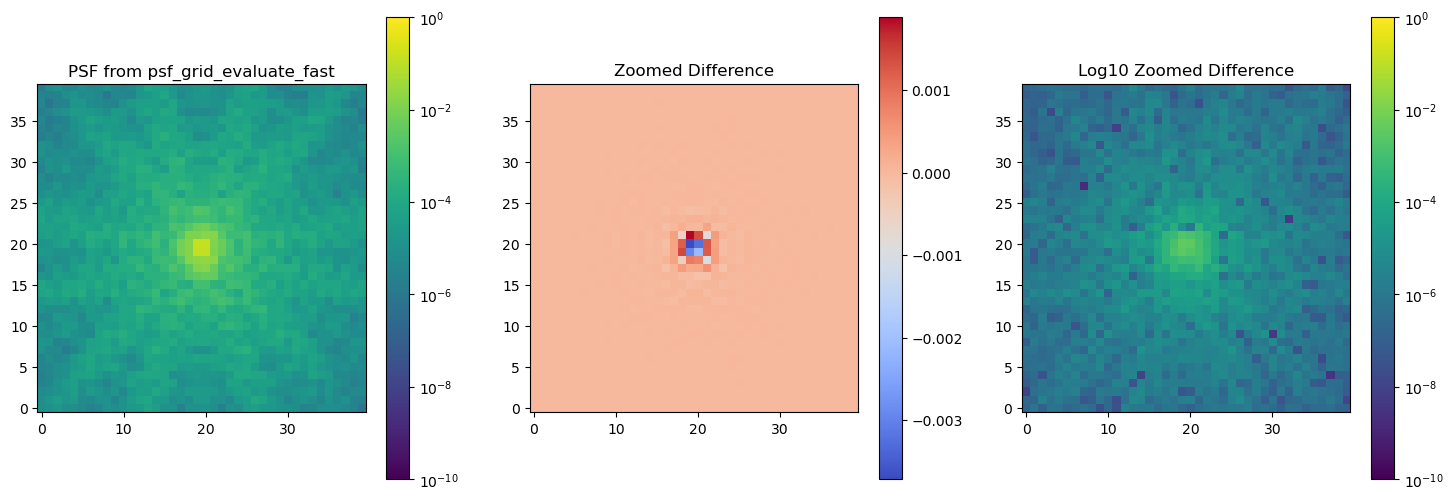

In [37]:
# Zoom into the central region 40x40 pixels of the difference, side by side with the full PSF
zoom_size = 40

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
# Show the actual PSF 
pixelcen = psf_grid_eval.shape[0] // 2
psf_grid_eval_zoom = psf_grid_eval[pixelcen-zoom_size//2:pixelcen+zoom_size//2, pixelcen-zoom_size//2:pixelcen+zoom_size//2]
plt.imshow(psf_grid_eval_zoom, origin='lower', cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e0))
plt.title("PSF from psf_grid_evaluate_fast")
plt.colorbar()

plt.subplot(1, 3, 2)
pixelcen = psf_diff.shape[0] // 2
psf_diff_zoom = psf_diff[pixelcen-zoom_size//2:pixelcen+zoom_size//2, pixelcen-zoom_size//2:pixelcen+zoom_size//2]
plt.imshow(psf_diff_zoom, origin='lower', cmap='coolwarm')
plt.title("Zoomed Difference")
plt.colorbar()

# Show the difference in log scale 
# Use the same plotting style as above
plt.subplot(1, 3, 3)
plt.imshow(np.abs(psf_diff_zoom), origin='lower', cmap='viridis', norm=LogNorm(vmin=1e-10, vmax=1e0))
plt.title("Log10 Zoomed Difference")
plt.colorbar()

plt.show()

In [39]:
# Print some statistics about the PSF difference
print(f"Max PSF1 : {np.max(psf_grid_eval):.3f}")
print(f"Max difference in PSF : {np.max(np.abs(psf_diff)):.3f}")

# Print sum of PSF and sum of absolute difference
print(f"Sum PSF1 : {np.sum(psf_grid_eval):.3f}")
print(f"Sum absolute difference : {np.sum(np.abs(psf_diff)):.3f}")

# Repeat sum for the zoomed PSF
print(f"Sum PSF1 zoomed : {np.sum(psf_grid_eval_zoom):.3f}")
print(f"Sum absolute difference zoomed : {np.sum(np.abs(psf_diff_zoom)):.3f}")

# Print the central pixel value of the zoomed PSF and the zoomed difference
central_pixel_value_psf = psf_grid_eval_zoom[zoom_size//2, zoom_size//2]
central_pixel_value_diff = psf_diff_zoom[zoom_size//2, zoom_size//2]
print(f"Central pixel value PSF1 : {central_pixel_value_psf:.3f}")
print(f"Central pixel value difference : {central_pixel_value_diff:.3f}")

Max PSF1 : 0.135
Max difference in PSF : 0.004
Sum PSF1 : 0.997
Sum absolute difference : 0.041
Sum PSF1 zoomed : 0.963
Sum absolute difference zoomed : 0.039
Central pixel value PSF1 : 0.132
Central pixel value difference : -0.003


### Random position test case

The test below isn't useful right now, since we have these pixel level shifts at the PSF level. That is something we'll need to track down at some point.

In [41]:
# Do a simple check of the results - look at the difference between the two methods
max_sum_flux = 0.0
max_abs_diff = 0.0
max_rel_diff = 0.0

mag_zero = 26.5  # Zero point magnitude for Roman

for istar in range(nstars):
    x = xpos[istar]
    y = ypos[istar]
    psf1 = iu.get_psf(wavelength=lam*1e-10, det="SCA01", detx=x, dety=y)[1].data
    psf2 = psf_grid_evaluate_fast(psf_grid, x, y, mag)

    sum_flux1 = np.sum(psf1)
    sum_flux2 = np.sum(psf2)

    max_sum_flux = max(max_sum_flux, sum_flux1)

    abs_diff = np.sum(np.abs(psf1 - psf2))
    rel_diff = abs_diff / sum_flux1

    max_abs_diff = max(max_abs_diff, abs_diff)
    max_rel_diff = max(max_rel_diff, rel_diff)

print(f"Max sum flux : {max_sum_flux:.3f}")
print(f"Max absolute difference : {max_abs_diff:.3f}")
print(f"Max relative difference : {max_rel_diff:.3f}")

Attempted to get aberrations at field point (3163, 3714) which is outside the range of the reference data; approximating to nearest interpolated point (3162.1954982732536, 2631.6770102837413)
Attempted to get aberrations at field point (1794, 2860) which is outside the range of the reference data; approximating to nearest interpolated point (1793.8310412261296, 2632.6941295531024)
Attempted to get aberrations at field point (2850, 3961) which is outside the range of the reference data; approximating to nearest interpolated point (2849.0120736888402, 2631.9098027202513)
Attempted to get aberrations at field point (384, 3183) which is outside the range of the reference data; approximating to nearest interpolated point (383.59173120031824, 2633.7423748281462)
Attempted to get aberrations at field point (3988, 2930) which is outside the range of the reference data; approximating to nearest interpolated point (3987.777797333895, 2631.0633465332007)
Attempted to get aberrations at field poin

Max sum flux : 0.997
Max absolute difference : 0.044
Max relative difference : 0.044
